### This notebooks introduces an alternative solution to the CNN-based model offered in the paper https://doi.org/10.1109/TEM.2020.3021698 . 
Note: It covers only the cpu type classification since the model in the paper nearly fit the data distribution to labels of the training data

In [16]:
import numpy as np
import pandas as pd
from googletrans import Translator
import random
import copy
import matplotlib.pyplot as plt

### First read the data files

In [4]:
# review data from amazon
review_train = np.load('./data/review.train.npz')
review_train_keys = [x for x in review_train.keys()]

In [9]:
# curated user needs dataset for training
need_train = np.load('need.train.npz')
need_train_keys = [x for x in need_train.keys()]

In [7]:
# curated user needs dataset for testing
need_test = np.load('need.test.npz')
need_test_keys = [x for x in need_test.keys()]

In [6]:
# the vocabulary authors used in the paper
vocab = {}

with open('vocab.txt', encoding = 'utf-8') as f:
    for i, line in enumerate(f.readlines()):
        vocab[i] = {'text':line[:-1], 'tfidf':[], 'count' : []}

### reading files in pandas tables

In [10]:
df_review_train = pd.DataFrame(columns = review_train_keys)
for i, line in enumerate(review_train['text']):
    temp = [vocab[x]['text'] for x in line if vocab[x]['text']!='<pad>' and vocab[x]['text']!='<unk>']
    df_review_train.loc[i,'text'] = " ".join(temp)
    df_review_train.loc[i,'screen_label'] =  review_train['screen_label'][i]
    df_review_train.loc[i,'cpu_label'] =  review_train['cpu_label'][i]
    df_review_train.loc[i,'ram_label'] =  review_train['ram_label'][i]
    df_review_train.loc[i,'hdd_label'] =  review_train['hdd_label'][i]
    df_review_train.loc[i,'gpu_label'] =  review_train['gpu_label'][i]
df_review_train.head()

,text,screen_label,cpu_label,ram_label,hdd_label,gpu_label
0,very compact ... nice ... fast browsing ...,0,6,0,0,2
1,i love it so far ... you ca n't go wrong .,0,6,0,0,2
2,"work really good , is very light and good",0,6,0,0,2
3,great laptop for the price .,3,6,2,5,7
4,very fast for what i use it for .,3,6,2,5,7


In [11]:
df_need_train = pd.DataFrame(columns = need_train_keys)
for i, line in enumerate(need_train['text']):
    temp = [vocab[x]['text'] for x in line if vocab[x]['text']!='<pad>' and vocab[x]['text']!='<unk>']
    df_need_train.loc[i,'text'] = " ".join(temp)
    df_need_train.loc[i,'screen_label'] =  need_train['screen_label'][i]
    df_need_train.loc[i,'cpu_label'] =  need_train['cpu_label'][i]
    df_need_train.loc[i,'ram_label'] =  need_train['ram_label'][i]
    df_need_train.loc[i,'hdd_label'] =  need_train['hdd_label'][i]
    df_need_train.loc[i,'gpu_label'] =  need_train['gpu_label'][i]
df_need_train.head()

,text,screen_label,cpu_label,ram_label,hdd_label,gpu_label
0,i am not finding a fancy computer but a powerf...,3,5,4,6,3
1,i am replacing my old computer which i want a ...,3,2,2,5,0
2,the computer should be light .,3,7,2,5,4
3,i need a real fast computer .,3,6,2,6,3
4,i need to bring my computer to school so i hop...,2,6,3,5,3


In [12]:
df_need_test = pd.DataFrame(columns = need_test_keys)
for i, line in enumerate(need_test['text']):
    temp = [vocab[x]['text'] for x in line if vocab[x]['text']!='<pad>' and vocab[x]['text']!='<unk>']
    df_need_test.loc[i,'text'] = " ".join(temp)
    df_need_test.loc[i,'screen_label'] =  need_test['screen_label'][i]
    df_need_test.loc[i,'cpu_label'] =  need_test['cpu_label'][i]
    df_need_test.loc[i,'ram_label'] =  need_test['ram_label'][i]
    df_need_test.loc[i,'hdd_label'] =  need_test['hdd_label'][i]
    df_need_test.loc[i,'gpu_label'] =  need_test['gpu_label'][i]
df_need_test.head()

,text,screen_label,cpu_label,ram_label,hdd_label,gpu_label
0,my old computer died suddenly and i need a new...,1,7,2,1,3
1,i am not a computer savvy and i want a compute...,4,4,2,5,3
2,i do some light gaming and i am finding an eco...,3,2,1,5,7
3,i need a definite improvement from my old lapt...,3,7,2,5,7
4,i need a computer with great build quality .,3,2,2,4,0


In [ ]:
df_review_train.drop_duplicates(inplace = True)

In [13]:
#combining tables as one dataset
df_train = df_review_train.append(df_need_train, ignore_index = True)

In [14]:
df_train.drop_duplicates(inplace = True)
df_train = df_train.dropna()

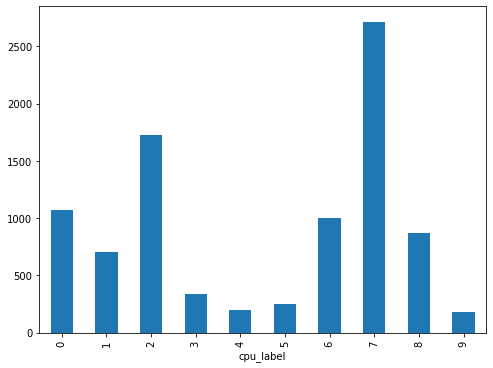

In [23]:
# CPU label distribution in train dataset
fig = plt.figure(figsize=(8,6))
df_train.groupby('cpu_label').text.count().plot.bar(ylim=0)
plt.show()

### Data augmentation by back-translation to solve the label imbalance situation above

In [33]:
from google.cloud import translate
from google.oauth2 import service_account

In [33]:
path_to_file = 'path to service account file'
credentials = service_account.Credentials.from_service_account_file(path_to_file)

In [34]:
client = translate.TranslationServiceClient(credentials=credentials)

In [45]:
def sample_translate_text(text, project_id, src, target, credentials):
    """Translating Text."""

    client = translate.TranslationServiceClient(credentials=credentials)

    parent = client.location_path(project_id, "global")

    # Detail on supported types can be found here:
    # https://cloud.google.com/translate/docs/supported-formats
    response = client.translate_text(
        parent=parent,
        contents=[text],
        mime_type="text/plain",  # mime types: text/plain, text/html
        source_language_code=src,
        target_language_code=target,
    )
    # Display the translation for each input text provided
    return_texts = []
    for translation in response.translations:
        return_texts.append(translation.translated_text)
    return return_texts


In [47]:
#destination languages
dest_langs = ['ja', 'de', 'es', 'hi', 'tr', 'zh-CN']

In [14]:
df_train.to_csv('df_train.csv')

In [51]:
df_train = pd.read_csv('df_train.csv')

In [ ]:
#completing each number of data points per each label to at least 1k
# NOTE: You can directly use the readily available one saved in ./data/df_train_with_augmentation.csv
your_project_id = 'your_project_id'
counts = df_train.groupby('cpu_label').text.count()
for i in range(9,len(counts)):
    if counts[i]<1000:
        temp_df = copy.deepcopy(df_train[df_train['cpu_label']==i])
        subs = 1000-counts[i]
        for j in range(subs):
            rand_i = random.choice(temp_df.index)
            temp_text = temp_df.loc[rand_i,'text']
            rand_lang = random.choice(dest_langs)
            a = sample_translate_text(text = temp_text, project_id = your_project_id, 
              src = 'en-US', target= rand_lang, credentials=credentials)[0]
            temp_df.loc[rand_i, 'text'] = sample_translate_text(text = a, project_id = your_project_id, 
              src = rand_lang, target= 'en-US', credentials=credentials)[0].lower()
            df_train = df_train.append(temp_df.loc[rand_i,:], ignore_index = True)
            print(i,'/9\t',j,'/',subs)

In [59]:
#number of train data points after augmentation
len(df_train)

12506

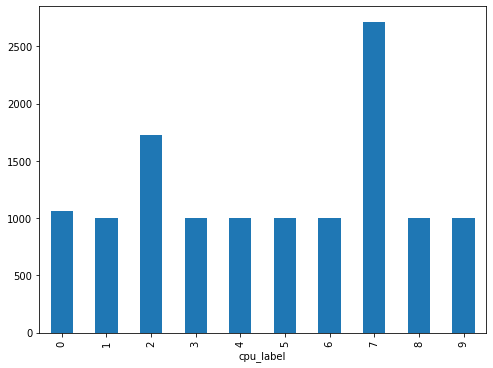

In [60]:
# distribution of data points to labels after augmentation
fig = plt.figure(figsize=(8,6))
df_train.groupby('cpu_label').text.count().plot.bar(ylim=0)
plt.show()

In [25]:
# I've already created augmented dataset. You can use this one instead
df_train = pd.read_csv('./data/df_train_with_augmentation.csv')

### bag of words with tfidf weights

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='utf-8', ngram_range=(1, 3), stop_words='english')
tfidf.fit(df_train.append(df_need_test).text)
features = tfidf.transform(df_train.text).toarray()
labels = [x for x in df_train.cpu_label]
features.shape

C:\Users\serhad\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(12506, 24986)

In [52]:
X_test = tfidf.transform(df_need_test.text).toarray()
y_test = [x for x in df_need_test.cpu_label]
X_test.shape

(450, 24986)

### Just used SVM classifier, without parameter exploration or so

In [53]:
from sklearn.svm import LinearSVC
model = LinearSVC(max_iter = 1000)
X_train = features
y_train = labels
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# xx = np.linspace(xlim[0], xlim[1], 30)
# yy = np.linspace(ylim[0], ylim[1], 30)
# YY, XX = np.meshgrid(yy, xx)
# xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Z = clf.decision_function(xy).reshape(XX.shape)

### Better performance compared to the model in the paper

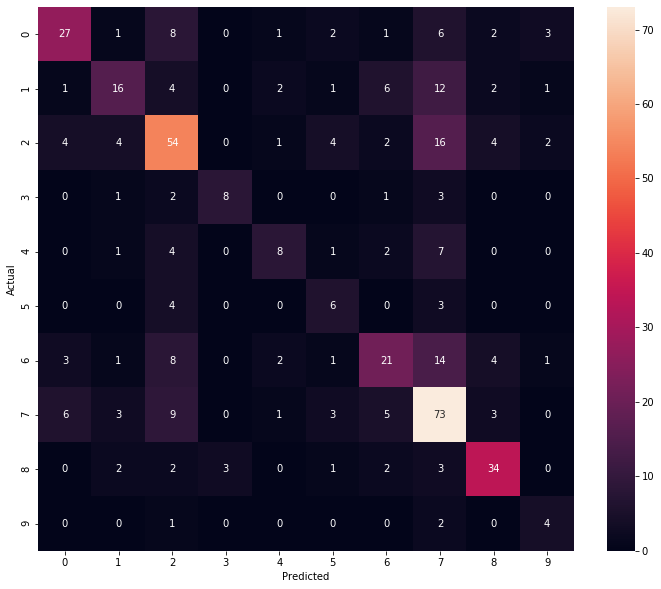

In [54]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,10))
import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(df_train.cpu_label.unique()), yticklabels=sorted(df_train.cpu_label.unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("output.png", bbox_inches="tight")
plt.show()

In [55]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=sorted([str(x) for x in df_train.cpu_label.unique()])))

              precision    recall  f1-score   support

           0       0.66      0.53      0.59        51
           1       0.55      0.36      0.43        45
           2       0.56      0.59      0.58        91
           3       0.73      0.53      0.62        15
           4       0.53      0.35      0.42        23
           5       0.32      0.46      0.37        13
           6       0.53      0.38      0.44        55
           7       0.53      0.71      0.60       103
           8       0.69      0.72      0.71        47
           9       0.36      0.57      0.44         7

    accuracy                           0.56       450
   macro avg       0.55      0.52      0.52       450
weighted avg       0.57      0.56      0.55       450

